# Image Classification with Deep Learning
Welcome to this Jupyter Notebook, where we will be deploying a deep learning model for image classification. This project utilizes a convolutional neural network (CNN) to differentiate between images of cats and dogs. Our dataset for this model is sourced from the widely used Cats and Dogs dataset available from https://www.microsoft.com/en-us/download/details.aspx?id=54765

## Objective
The goal of this notebook is to demonstrate the practical application of a CNN in image classification. We aim to achieve the following:

- Preprocess and prepare a dataset for model training.
- Construct and train a CNN on this dataset.
- Evaluate the model's performance to ensure it meets our criteria for accuracy and efficiency.

## Dataset
We use the Cats and Dogs dataset, which provides a balanced number of images for both classes, making it ideal for our classification model. This dataset is a common benchmark in the field of computer vision and helps in understanding model behavior on real-world data.

## Tools and Libraries
In this project, we will utilize the following tools and libraries:

- PyTorch: Our main framework for modeling and training.
- NumPy: For handling data manipulations.
- Matplotlib: To visualize images and training results.

In [1]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Setting Up the Compute Device

To ensure our model runs efficiently, we need to configure the compute device that our training process will utilize. The following code snippet automatically selects a GPU if one is available, otherwise it falls back to using the CPU. This setup helps in leveraging hardware acceleration provided by GPUs, which can significantly speed up the training process.

In [53]:
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda:1


# Data Preprocessing and Augmentation

Before training the neural network, it's crucial to prepare and augment the images. This enhances the robustness of the model and improves its ability to generalize.

These transformations ensure that each image loaded into our model is resized, optionally flipped, color-adjusted, and properly normalized. These steps are crucial for effective training.

### Setting Up Data Loaders

After defining our transformations, we prepare our dataset into training, validation, and testing sets. This segmentation is essential for training on a variety of images, validating performance on unseen data, and testing the model's effectiveness.

In [36]:
# Define transformations including data augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


batch_size = 64

BASE_DATA_DIR = '../../data/CleanedPetImages'

train_data = datasets.ImageFolder(root=os.path.join(BASE_DATA_DIR, 'train'), transform=transform)
val_data = datasets.ImageFolder(root=os.path.join(BASE_DATA_DIR, 'val'), transform=transform)
test_data = datasets.ImageFolder(root=os.path.join(BASE_DATA_DIR, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


# Visualizing Training Data

It's often beneficial to visualize the training data to understand its distribution and quality. This section of the notebook demonstrates how to display a grid of images with their corresponding labels using matplotlib.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..1.6639653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6726604..1.4896734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4929972..2.2216995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..1.4199566]

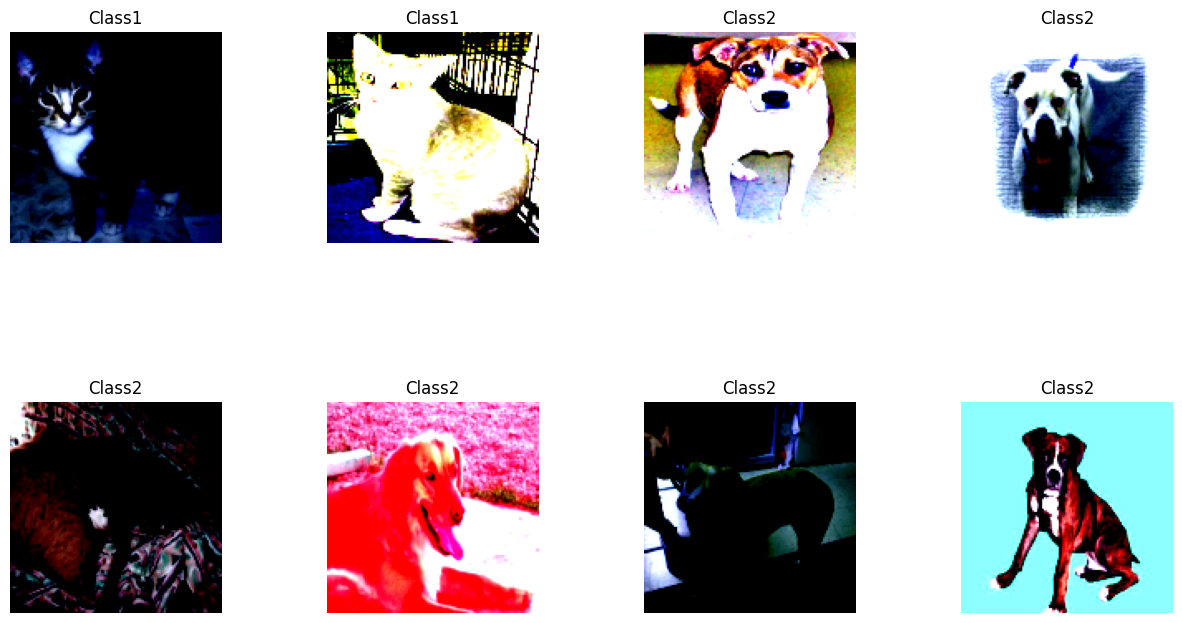

In [37]:
# Function to display a grid of images with labels
def show_images_labels(image_batch, label_batch, label_map):
    fig, axs = plt.subplots(2, 4, figsize=(15, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i in range(2):
        for j in range(4):
            index = i * 4 + j
            image = image_batch[index]
            label = label_batch[index].item()
            axs[i, j].imshow(image.permute(1, 2, 0))
            axs[i, j].set_title(label_map[label])
            axs[i, j].axis('off')
    plt.show()

# Create a DataLoader with shuffle enabled to get random samples
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

# Define a label map (replace with actual class labels)
label_map = {0: "Class1", 1: "Class2"}

# Get a batch of images
images, labels = next(iter(train_loader))

# Display the batch of images with labels
show_images_labels(images, labels, label_map)

In [ ]:
from custom_classifier.model import CustomModel

# Model Configuration and Setup

This section outlines the configuration and initialization of our deep learning model for the image classification task. Here, we define the input shape and the number of classes, and we initialize our custom model with these parameters.

In [58]:
input_shape = (3, 128, 128)  # Assuming input images are 128x128 RGB
num_classes = 2  # Number of output classes

model = CustomModel(input_shape, num_classes).to(DEVICE)

<All keys matched successfully>

# Training and Validation Loop

In this section, we define and execute the training loop for our deep learning model. This loop will manage both the training and validation phases over a specified number of epochs.



1. **Setup**: We start by importing `tqdm` for progress visualization, defining the loss function, optimizer, and data loaders. The `DataLoader` shuffles the training data to ensure diversity in the training samples seen by the model during each epoch.

2. **Training Loop**: Each epoch involves setting the model to training mode, iterating over the training data, computing the loss, and updating the model parameters. Loss and accuracy statistics are tracked and printed.

3. **Validation Loop**: After training, the model is set to evaluation mode, and the validation set is processed similarly to the training loop but without updating model parameters. This phase assesses the model's performance on unseen data.

4. **Output**: After each epoch, a detailed summary of training and validation loss and accuracy is printed. This output helps in monitoring the model’s performance and convergence over the training process.

This training and validation structure is essential for developing robust deep learning models, allowing for continuous monitoring and adjustment as needed.


In [59]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()  # Since we're using sparse categorical cross-entropy, no need to use softmax activation in the last layer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (images, labels) in progress_bar:
        optimizer.zero_grad()
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to GPU
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / ((batch_idx + 1) * batch_size):.4f}')

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100. * correct_train / len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100. * correct_val / len(val_loader.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Epoch [1/20], Train Loss: 0.2651: 100%|██████████| 321/321 [01:09<00:00,  4.61it/s]


Epoch [1/20], Train Loss: 0.2659, Train Acc: 88.57%, Val Loss: 0.2445, Val Acc: 90.08%


Epoch [2/20], Train Loss: 0.2382: 100%|██████████| 321/321 [01:12<00:00,  4.44it/s]


Epoch [2/20], Train Loss: 0.2389, Train Acc: 90.04%, Val Loss: 0.2417, Val Acc: 89.58%


Epoch [3/20], Train Loss: 0.2253: 100%|██████████| 321/321 [01:13<00:00,  4.36it/s]


Epoch [3/20], Train Loss: 0.2259, Train Acc: 90.60%, Val Loss: 0.2416, Val Acc: 89.18%


Epoch [4/20], Train Loss: 0.2091: 100%|██████████| 321/321 [01:15<00:00,  4.26it/s]


Epoch [4/20], Train Loss: 0.2097, Train Acc: 91.23%, Val Loss: 0.2359, Val Acc: 89.94%


Epoch [5/20], Train Loss: 0.1958: 100%|██████████| 321/321 [01:13<00:00,  4.38it/s]


Epoch [5/20], Train Loss: 0.1964, Train Acc: 92.01%, Val Loss: 0.2108, Val Acc: 91.27%


Epoch [6/20], Train Loss: 0.1910: 100%|██████████| 321/321 [01:13<00:00,  4.37it/s]


Epoch [6/20], Train Loss: 0.1916, Train Acc: 92.14%, Val Loss: 0.2171, Val Acc: 90.48%


Epoch [7/20], Train Loss: 0.1778: 100%|██████████| 321/321 [01:10<00:00,  4.52it/s]


Epoch [7/20], Train Loss: 0.1783, Train Acc: 92.77%, Val Loss: 0.2136, Val Acc: 91.27%


Epoch [8/20], Train Loss: 0.1688: 100%|██████████| 321/321 [01:10<00:00,  4.56it/s]


Epoch [8/20], Train Loss: 0.1693, Train Acc: 93.23%, Val Loss: 0.2030, Val Acc: 91.85%


Epoch [9/20], Train Loss: 0.1607: 100%|██████████| 321/321 [01:11<00:00,  4.51it/s]


Epoch [9/20], Train Loss: 0.1612, Train Acc: 93.45%, Val Loss: 0.2108, Val Acc: 91.06%


Epoch [10/20], Train Loss: 0.1508: 100%|██████████| 321/321 [01:12<00:00,  4.44it/s]


Epoch [10/20], Train Loss: 0.1513, Train Acc: 93.74%, Val Loss: 0.1965, Val Acc: 92.07%


Epoch [11/20], Train Loss: 0.1425: 100%|██████████| 321/321 [01:17<00:00,  4.15it/s]


Epoch [11/20], Train Loss: 0.1429, Train Acc: 94.39%, Val Loss: 0.2040, Val Acc: 91.71%


Epoch [12/20], Train Loss: 0.1443: 100%|██████████| 321/321 [01:15<00:00,  4.24it/s]


Epoch [12/20], Train Loss: 0.1447, Train Acc: 94.32%, Val Loss: 0.1984, Val Acc: 92.39%


Epoch [13/20], Train Loss: 0.1711: 100%|██████████| 321/321 [01:14<00:00,  4.29it/s]


Epoch [13/20], Train Loss: 0.1715, Train Acc: 93.05%, Val Loss: 0.1940, Val Acc: 92.35%


Epoch [14/20], Train Loss: 0.1501: 100%|██████████| 321/321 [01:14<00:00,  4.33it/s]


Epoch [14/20], Train Loss: 0.1506, Train Acc: 93.90%, Val Loss: 0.1882, Val Acc: 92.14%


Epoch [15/20], Train Loss: 0.1346: 100%|██████████| 321/321 [01:11<00:00,  4.52it/s]


Epoch [15/20], Train Loss: 0.1350, Train Acc: 94.67%, Val Loss: 0.1842, Val Acc: 93.44%


Epoch [16/20], Train Loss: 0.1182: 100%|██████████| 321/321 [01:12<00:00,  4.42it/s]


Epoch [16/20], Train Loss: 0.1185, Train Acc: 95.45%, Val Loss: 0.1785, Val Acc: 92.86%


Epoch [17/20], Train Loss: 0.1142: 100%|██████████| 321/321 [01:16<00:00,  4.21it/s]


Epoch [17/20], Train Loss: 0.1145, Train Acc: 95.59%, Val Loss: 0.1873, Val Acc: 92.82%


Epoch [18/20], Train Loss: 0.1094: 100%|██████████| 321/321 [01:11<00:00,  4.50it/s]


Epoch [18/20], Train Loss: 0.1097, Train Acc: 95.75%, Val Loss: 0.1821, Val Acc: 93.08%


Epoch [19/20], Train Loss: 0.1084: 100%|██████████| 321/321 [01:10<00:00,  4.52it/s]


Epoch [19/20], Train Loss: 0.1088, Train Acc: 95.74%, Val Loss: 0.1774, Val Acc: 92.97%


Epoch [20/20], Train Loss: 0.0987: 100%|██████████| 321/321 [01:10<00:00,  4.53it/s]


Epoch [20/20], Train Loss: 0.0990, Train Acc: 96.14%, Val Loss: 0.1763, Val Acc: 93.44%


In [61]:
torch.save(model.state_dict(), 'models/model-val-93.pth')

In [4]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Define the transformation to apply to the input image
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = CustomModel(input_shape=(3, 128, 128), num_classes=2) 
model.load_state_dict(torch.load('models/model-val-93.pth'))

# Define the class labels
class_labels = ['cat', 'dog']

# Function to predict whether the image contains a cat or a dog
def predict(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension
    
    # Move the input tensor to the same device as the model
    image = image.to(next(model.parameters()).device)
    
    # Perform inference
    with torch.no_grad():
        model.eval()
        outputs = model(image)
        print(outputs)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_label = class_labels[predicted_idx.item()]
    
    return predicted_label

# Example usage:
image_path = input("Enter file path: ")  # Update with the image file path
prediction = predict(image_path)
print(f'The image contains a {prediction}.')


tensor([[-0.0286, -0.6372]])
The image contains a cat.
